# 🐕🐈 Animal Classification using Pytorch and Transfer Learning:

Image classification, a fundamental concept within computer vision, revolves around the process of assigning labels or categories to images based on their content. What was once a complex endeavor involving manual feature engineering and traditional machine learning has now evolved, thanks to the advent of deep learning models.

In this project, I will use 3 remarkable such models (EfficientNet, VisionTransformer and BiT-50), that have been shown to perform extremely well on various image classification tasks and have been state of the art, acheiving incredible performance on Benchmarks such as ImageNet and CIFAR.



## 🏗️ Imports: 

In [1]:
!pip install -q torchsummary

In [2]:
import os
import random 
import shutil
import cv2
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import transforms as T, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.backends.cudnn as cudnn
from torchsummary import summary
from torchvision.datasets import CIFAR10
from tempfile import TemporaryDirectory

from transformers import BitForImageClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Splitting data into a train/valid/test subset:

In [3]:
data_path = "/kaggle/input/animals10/raw-img"
labels = os.listdir(data_path)
NUM_CLASSES = len(labels)

In [4]:
# Define the new top-level directory names
directories = ['train', 'val', 'test']

# Define the subdirectory names for each top-level directory
subdirectories = labels

# Define the proportions for train, validation, and test sets
props = [0.95, 0.04, 0.01]

# Loop over the top-level directories and subdirectories, and create the corresponding directories
for directory in directories:
    for subdirectory in subdirectories:
        path = os.path.join(data_path, subdirectory)
        files = os.listdir(path)
        random.shuffle(files)
        total = len(files)
        train_end = int(total * props[0])
        val_end = train_end + int(total * props[1])
        if directory == 'train':
            new_files = files[:train_end]
        elif directory == 'val':
            new_files = files[train_end:val_end]
        else:
            new_files = files[val_end:]
        new_path = os.path.join(directory, subdirectory)
        os.makedirs(new_path, exist_ok=True)
        for file in new_files:
            old_file_path = os.path.join(path, file)
            new_file_path = os.path.join(new_path, file)
            shutil.copy(old_file_path, new_file_path)

## 📥 Creating Loader functions : 
Using torchvision, we will load our dataset. We will create some helper functions that makes pre-processing pretty easy and straight-forward. Let's define the functions get_train_valid_loader and get_test_loader, so we can call them to load in and process our data:

In [5]:
def get_train_valid_loader(train_dir,
                           val_dir,
                           batch_size,
                           augment = True,
                           resize_shape = (224,224),
                           random_seed = 42,
                           shuffle=True):
    normalize = T.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225],
    )

    # define transforms
    valid_transform = T.Compose([
            T.Resize(resize_shape),
            T.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = T.Compose([
            T.Resize(resize_shape),
            T.RandomRotation(degrees=(0, 20)),
            T.RandomHorizontalFlip(),
            T.ColorJitter(brightness=0.5, contrast=0.5, saturation = 0.5),
            T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            T.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            T.Resize(resize_shape),
            T.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.ImageFolder(
        root=train_dir, transform=train_transform
    )
    
    valid_dataset = datasets.ImageFolder(
        root=val_dir, transform=valid_transform,
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,shuffle=shuffle)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size,shuffle=shuffle)

    
    label_mapping = train_dataset.class_to_idx
    
    
    return (train_loader, len(train_dataset), valid_loader, len(valid_dataset),label_mapping)


In [6]:
def get_test_loader(test_dir,
                    batch_size,
                    resize_shape = (224,224),
                    random_seed = 42,
                    shuffle=True):
    normalize = T.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225],
    )

    # define transforms
    test_transform = T.Compose([
            T.Resize((384,384)),
            T.ToTensor(),
            normalize,
    ])
    test_dataset = datasets.ImageFolder(
        root=test_dir, transform=test_transform,
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,shuffle=shuffle)

    return (test_loader, len(test_dataset))


In [7]:
train_loader,num_train, valid_loader, num_valid, label_mapping = get_train_valid_loader(train_dir = '/kaggle/working/train',val_dir = "/kaggle/working/val" ,batch_size = 32,
                       augment = True,random_seed = 1)

In [8]:
test_loader, num_test = get_test_loader(test_dir = "/kaggle/working/test", batch_size = 32)

## Creating useful functions and tools :

In [9]:
def get_className(class_index): 
    return list(label_mapping.keys())[list(label_mapping.values()).index(class_index)]

In [10]:
with open("/kaggle/input/animals10/translate.py") as f: 
    print(f.readline())

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}



In [11]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "cane": "dog", "cavallo": "horse", "elefante" : "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "ragno": "spider", "scoiattolo": "squirrel"}

In [12]:
def get_missclassified(test_dataset, model):
    missclassified = []
    true_label = []
    preds = []
    for i, (img, label) in enumerate(test_dataset):
        img = img.unsqueeze(0) 
        img = img.to(device)
        model.eval()
        outputs = model(img)
        _, pred = torch.max(outputs, 1)
        if(pred.item() != label): 
            missclassified.append(img.squeeze(0))
            true_label.append(label)
            preds.append(pred.cpu().numpy())
    return missclassified, true_label, preds

### Function to visualize images:

In [13]:
def imshow(image, ax=None, normalized=True,  **imshow_kwargs):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalized:
        mean = np.array([0.38, 0.37, 0.37])
        std = np.array([0.3, 0.27, 0.28])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image,  **imshow_kwargs)   
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    
def plot(imgs,labels, tensor, n_cols, n_rows=None, figsize=(20, 15), normalized = True, row_title=None,  **imshow_kwargs):
    n_cols = n_cols
    if n_rows is None:
        n_rows = int(len(imgs)/n_cols)
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False, figsize=figsize)
    for i in range(len(imgs)):
        img = imgs[i]
        if tensor:
            imshow(img,axs[i//n_cols, i%n_cols], normalized = normalized)
            axs[i//n_cols, i%n_cols].axis('off')
            axs[i//n_cols, i%n_cols].set_title("Label: {}".format(labels[i]))
        else: 
            axs[i//n_cols, i%n_cols].imshow(img)
            axs[i//n_cols, i%n_cols].set_title("Label: {}".format(labels[i]))

    if row_title is not None:
        for row_idx in range(n_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])


# Implement Early Stopping:

In [14]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Training Function:

In [15]:
def train_model(model,criterion, optimizer, architecture = None,  num_epochs=25):
    since = time.time()
    torch.save(model.state_dict(), f"/kaggle/working/best_model_{architecture}")
    best_acc = 0.0
    early_stopper = EarlyStopper(patience=7, min_delta=0.01)
    early_stop = False
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if(architecture == "BiT"):
                        outputs = model(inputs).logits
                    else: 
                        outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' :
                if early_stopper.early_stop(epoch_loss):
                    early_stop = True
                    break
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), f"/kaggle/working/best_model_{architecture}")
        if early_stop:
            print("Early Stopping triggered.")
            break
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(f"/kaggle/working/best_model_{architecture}"))
    return model

### Test Evaluation Function:

In [16]:
def predict(model, dataloader, test_size): 
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.eval()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    loss = running_loss / test_size
    acc = running_corrects.double() / test_size
    return loss, acc

## 🔭Visualizing images from the dataset

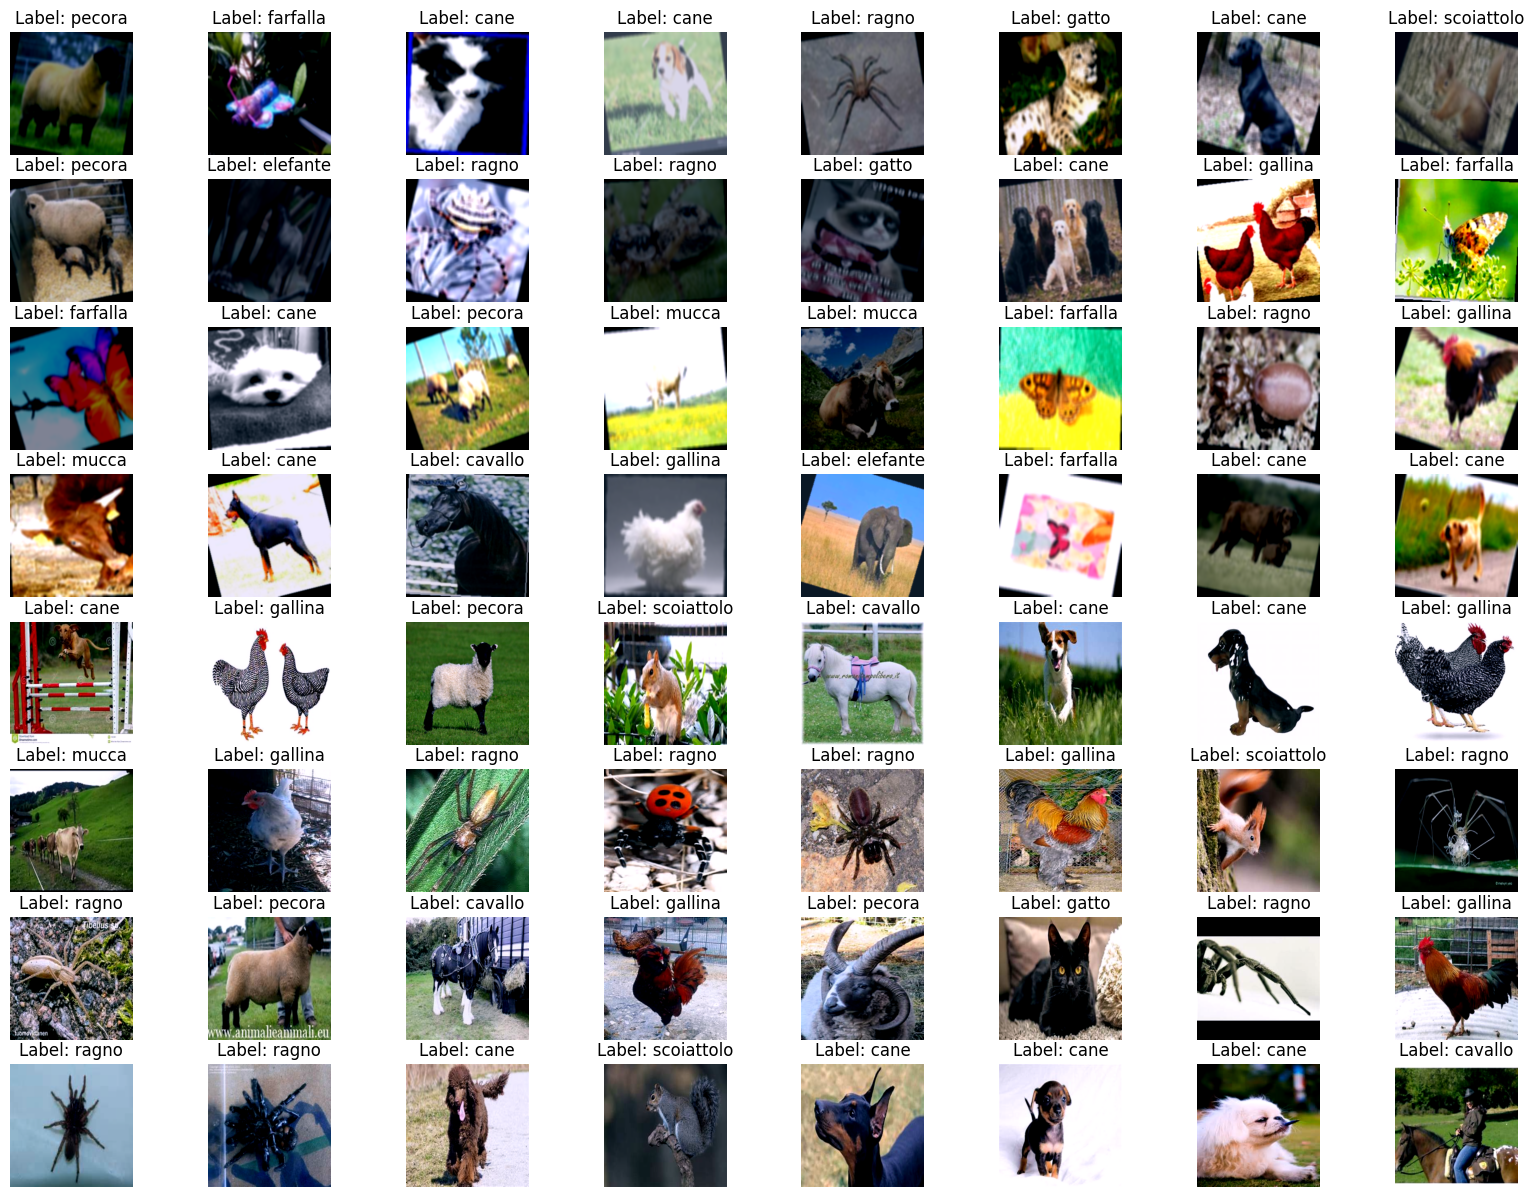

In [17]:
# Get the next images, labels in the train_loader
images, labels = next(iter(train_loader))
# Get the class names from the label ids
label_names = [list(label_mapping.keys())[list(label_mapping.values()).index(i)] for i in labels]
# Get the next val_images,val_labels from the valid_loader
val_images, val_labels = next(iter(valid_loader))
# Get the class names from the label ids
val_label_names = [list(label_mapping.keys())[list(label_mapping.values()).index(i)] for i in val_labels]

#Visualize images
plot(torch.cat((images, val_images), 0),label_names + val_label_names, n_cols = 8, tensor = True, normalized=True)

### Test Data:

In [18]:
test_transform = T.Compose([
            T.Resize((384,384)),
            T.ToTensor(),
    ])
test_dataset = datasets.ImageFolder(
        root="/kaggle/working/test", transform=test_transform,
    )

## Fine-Tuning EfficientNet:

### About EfficientNet: 
Scaling up ConvNets is known to achieve better accuracy. ResNet can be scaled up from ResNet-18 to ResNet-152 and ResNet-200 by using more layers. The process of scaling-up ConvNets have been well understood and there are many ways to do it. The most common way is scaling them by their depth, or width. Another less common but increasingly popular is to scale up models by image resolution. In previous works, it is common to scale only one of the three dimensions, width, depth and image size. 

In EfficientNet paper, the idea is to rethink the process of scaling up ConvNet. Is there a way to scale up ConvNets that can achieve better accuracy and efficiency?

In [19]:
train_loader,num_train, valid_loader, num_valid, label_mapping = get_train_valid_loader(train_dir = '/kaggle/working/train',val_dir = "/kaggle/working/val" ,batch_size = 32,
                       resize_shape = (384,384),augment = True,random_seed = 1)

In [20]:
dataloaders = {"train" : train_loader,"val" : valid_loader}
dataset_sizes = {"train" : num_train,"val" : num_valid}

In [21]:
model = models.efficientnet_v2_l(weights = "IMAGENET1K_V1").to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:11<00:00, 42.4MB/s] 


In [22]:
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [23]:
model = train_model(model, criterion, optimizer, architecture = "EfficientNet",num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4108 Acc: 0.8892
val Loss: 0.1337 Acc: 0.9750

Epoch 1/4
----------
train Loss: 0.2491 Acc: 0.9258
val Loss: 0.1107 Acc: 0.9721

Epoch 2/4
----------
train Loss: 0.2474 Acc: 0.9254
val Loss: 0.0970 Acc: 0.9740

Epoch 3/4
----------


KeyboardInterrupt: 

In [28]:
loss, acc = predict(model,test_loader,num_test)

In [29]:
print(f"Loss on test: {loss:.2f}\nAccuracy on test: {acc:.2f} ")

Loss on test: 0.14
Accuracy on test: 0.96 


In [30]:
missclassified, true_label, preds = get_missclassified(test_dataset,model)

In [31]:
imgs = [missclassified[i].cpu() for i in range(len(missclassified))]
labels = [f" {translate[get_className(true_label[i])]}\n predicted : {translate[get_className(preds[i])]}" for i in range(len(preds))]

In [32]:
n_cols = 6
n_rows = int(len(missclassified)/n_cols)
n_images = int(len(missclassified)/n_cols) * n_cols

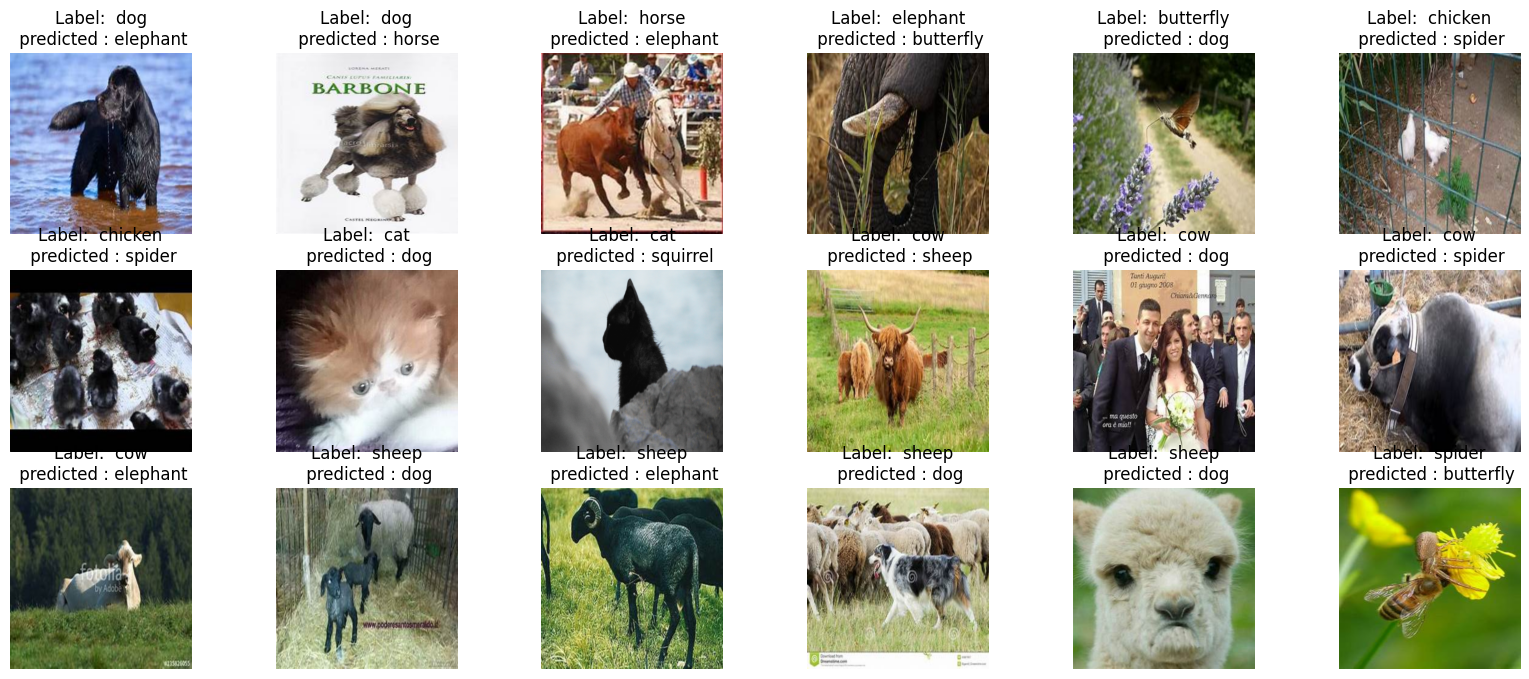

In [33]:
plot(imgs[:n_images],labels, tensor = True,  n_cols = n_cols, n_rows = n_rows, normalized = False, figsize = (20,8))

### Vision Transformer: 
Vision Transformer is an architecture based on the encoder part of the famous transformer architecture widely used in NLP, the idea being instead of having sentence tokens as input to the encoder, we would have image patches instead. VisionTransformers have shown to get great performance on image classification taks, especially when trained on large data and then using transfer learning to fine tune it to a smaller data.

In [34]:
vit_model = models.vit_b_16(weights = "IMAGENET1K_SWAG_E2E_V1").to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:08<00:00, 41.7MB/s] 


In [35]:
for param in vit_model.parameters():
    param.requires_grad = False
    
num_ftrs = vit_model.heads[0].in_features
vit_model.heads[0] = nn.Linear(num_ftrs, 10)
vit_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr = 0.001)

In [36]:
model = train_model(vit_model, criterion, optimizer,architecture = "ViT",num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1064 Acc: 0.9731
val Loss: 0.0337 Acc: 0.9942

Epoch 1/4
----------
train Loss: 0.0636 Acc: 0.9825
val Loss: 0.0310 Acc: 0.9923

Epoch 2/4
----------
train Loss: 0.0529 Acc: 0.9856
val Loss: 0.0228 Acc: 0.9962

Epoch 3/4
----------
train Loss: 0.0476 Acc: 0.9865
val Loss: 0.0247 Acc: 0.9933

Epoch 4/4
----------
train Loss: 0.0468 Acc: 0.9868
val Loss: 0.0254 Acc: 0.9913

Training complete in 88m 30s
Best val Acc: 0.996154


In [37]:
missclassified, true_label, preds = get_missclassified(test_dataset,vit_model)

In [38]:
imgs = [missclassified[i].cpu() for i in range(len(missclassified))]
labels = [f" {translate[get_className(true_label[i])]}\n predicted : {translate[get_className(preds[i])]}" for i in range(len(preds))]

In [39]:
n_cols = 6
n_rows = int(len(missclassified)/n_cols)
n_images = int(len(missclassified)/n_cols) * n_cols

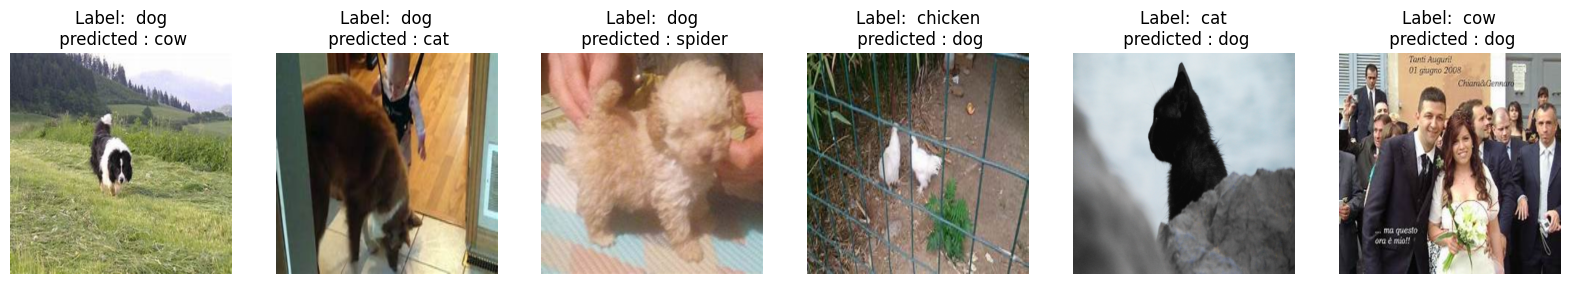

In [40]:
plot(imgs[:n_images],labels, tensor = True,  n_cols = n_cols, n_rows = n_rows, normalized = False, figsize = (20,8))

### Big Transfer learning: 
BiT capitalizes on the power of transfer learning, having been pre-trained on extensive datasets to transfer knowledge effectively to other dataset later on.

In [41]:
model = BitForImageClassification.from_pretrained("google/bit-50")

In [42]:
train_loader,num_train, valid_loader, num_valid, label_mapping = get_train_valid_loader(train_dir = '/kaggle/working/train',val_dir = "/kaggle/working/val" ,batch_size = 32,
                       resize_shape = (448,448),augment = True,random_seed = 1)

In [43]:
dataloaders = {"train" : train_loader,"val" : valid_loader}
dataset_sizes = {"train" : num_train,"val" : num_valid}

In [44]:
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

### Redefine train function:


In [ ]:
model = train_model(model, criterion, optimizer,architecture = "BiT",num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1691 Acc: 0.9554
val Loss: 0.0811 Acc: 0.9817

Epoch 1/4
----------
train Loss: 0.1339 Acc: 0.9700
val Loss: 0.0363 Acc: 0.9904

Epoch 2/4
----------


In [ ]:
missclassified, true_label, preds = get_missclassified(test_dataset,model)

In [ ]:
imgs = [missclassified[i].cpu() for i in range(len(missclassified))]
labels = [f" {translate[get_className(true_label[i])]}\n predicted : {translate[get_className(preds[i])]}" for i in range(len(preds))]

In [ ]:
n_cols = 6
n_rows = int(len(missclassified)/n_cols)
n_images = int(len(missclassified)/n_cols) * n_cols

In [ ]:
plot(imgs[:n_images],labels, tensor = True,  n_cols = 5, normalized = False, figsize = (20,8))